<a href="https://colab.research.google.com/github/mighty-mass/ai-engineer-course/blob/main/DeepLearning/VisionTechSolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Riconoscimento di animali per auto a guida autonoma
VisionTech Solutions vuole sviluppare un sistema di riconoscimento automatico delle immagini per distinguere tra veicoli e animali, con l'obiettivo di ottimizzare le operazioni di monitoraggio della fauna nelle aree urbane, evitando incidenti stradali e proteggendo sia gli animali che i veicoli.

VisionTech Solutions collabora con le amministrazioni comunali per implementare un sistema di monitoraggio in tempo reale nelle città, utilizzando telecamere installate lungo le strade per identificare e classificare veicoli e animali. Questo sistema aiuterà a prevenire incidenti stradali causati dall'attraversamento improvviso di animali, avvisando i guidatori tramite segnali stradali elettronici.

Benefici:

1. Automazione dei Processi:
- Riduzione del tempo e delle risorse per monitorare manualmente le aree urbane.
- Rilevamento automatico e in tempo reale di animali e veicoli.
2. Aumento della Precisione:
- Utilizzo di una rete neurale convoluzionale (CNN) per garantire alta precisione nella classificazione delle immagini.
- Minimizzazione degli errori umani.
3. Efficienza Operativa:
- Processamento rapido e accurato di grandi volumi di dati, migliorando la risposta agli eventi.
- Maggiore sicurezza per i cittadini e riduzione dei danni ai veicoli.
4. Applicazioni Multiple:
- Sorveglianza e monitoraggio del traffico.
- Analisi del comportamento animale nelle aree urbane.
- Utilizzo dei dati per migliorare le politiche di sicurezza stradale.

## Dettagli del Progetto:

1. Dataset:
- Utilizzo del dataset CIFAR, contenente migliaia di immagini etichettate in varie categorie, inclusi veicoli e animali.
2. Algoritmo:
- Implementazione di una rete neurale convoluzionale (CNN) per l'analisi e la classificazione delle immagini.
3. Output:
- Il sistema classificherà correttamente ogni immagine come veicolo o animale.

## Valutazione del Modello:

- **Accuratezza**: Proporzione di immagini classificate correttamente rispetto al totale.
- **Precisione**: Qualità delle predizioni positive, indicando la proporzione di immagini correttamente identificate.

## Analisi dei Risultati:

- Identificazione di eventuali pattern di errore.
- Valutazione delle categorie di immagini confuse sistematicamente.
- Esame delle immagini errate e riflessione su possibili migliorie al modello.

## Risultato Finale:

- Presentazione completa della rete neurale convoluzionale e delle sue capacità di discriminazione tra veicoli e animali.
- Discussione dettagliata delle metriche utilizzate e un'analisi critica delle prestazioni e limitazioni del modello.

Questo progetto fornirà a VisionTech Solutions un sistema efficace per migliorare la sicurezza stradale e la gestione della fauna nelle aree urbane, dimostrando le competenze pratiche nell'applicazione del machine learning al riconoscimento delle immagini.

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import Image
import seaborn as sns
import pandas as pd
import os
import time

Le classi di CIFAR-10 sono:
* 0: aereo
* 1: automobile
* 2: uccello
* 3: gatto
* 4: cervo,
* 5: cane
* 6: rana
* 7: cavallo
* 8: nave
* 9: camion
    
Mappiamo le classi originali a classi binarie:
- Veicoli (0): aereo (0), automobile (1), nave (8), camion (9)
- Animali (1): uccello (2), gatto (3), cervo (4), cane (5), rana (6), cavallo (7)

In [13]:
def load_and_prepare_cifar10():
    """
    Carica e prepara il dataset CIFAR-10, selezionando solo le classi di interesse:
    - Veicoli: automobile, camion, nave, aereo
    - Animali: uccello, gatto, cervo, cane, rana, cavallo
    """
    print("Caricamento del dataset CIFAR-10...")
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()

    # Creazione della mappa delle classi
    class_mapping = {
        0: 0,  # aereo -> veicolo
        1: 0,  # automobile -> veicolo
        2: 1,  # uccello -> animale
        3: 1,  # gatto -> animale
        4: 1,  # cervo -> animale
        5: 1,  # cane -> animale
        6: 1,  # rana -> animale
        7: 1,  # cavallo -> animale
        8: 0,  # nave -> veicolo
        9: 0   # camion -> veicolo
    }

    # Applicazione della mappatura
    y_train_binary = np.array([class_mapping[y[0]] for y in y_train])
    y_test_binary = np.array([class_mapping[y[0]] for y in y_test])

    # Separazione degli indici di validazione dal set di addestramento
    x_train, x_val, y_train_binary, y_val_binary = train_test_split(
        x_train, y_train_binary, test_size=0.2, random_state=42, stratify=y_train_binary
    )

    # Normalizzazione dei dati (0-255 -> 0-1)
    x_train = x_train.astype('float32') / 255.0
    x_val = x_val.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0

    # One-hot encoding per le etichette (anche se sono binarie)
    y_train_binary = to_categorical(y_train_binary, 2)
    y_val_binary = to_categorical(y_val_binary, 2)
    y_test_binary = to_categorical(y_test_binary, 2)

    class_names = ['Veicolo', 'Animale']

    print(f"Dati preparati. Forma dei dati:")
    print(f"  Train: {x_train.shape} con {len(y_train_binary)} etichette")
    print(f"  Validation: {x_val.shape} con {len(y_val_binary)} etichette")
    print(f"  Test: {x_test.shape} con {len(y_test_binary)} etichette")

    return (x_train, y_train_binary), (x_val, y_val_binary), (x_test, y_test_binary), class_names

load_and_prepare_cifar10()

Caricamento del dataset CIFAR-10...
Dati preparati. Forma dei dati:
  Train: (40000, 32, 32, 3) con 40000 etichette
  Validation: (10000, 32, 32, 3) con 10000 etichette
  Test: (10000, 32, 32, 3) con 10000 etichette


((array([[[[0.09803922, 0.07843138, 0.10196079],
           [0.09803922, 0.07843138, 0.10196079],
           [0.09411765, 0.07450981, 0.09803922],
           ...,
           [0.07450981, 0.05882353, 0.0627451 ],
           [0.07450981, 0.05882353, 0.07450981],
           [0.07450981, 0.05490196, 0.07843138]],
  
          [[0.09411765, 0.07450981, 0.09803922],
           [0.09411765, 0.07450981, 0.09803922],
           [0.09411765, 0.07450981, 0.09803922],
           ...,
           [0.06666667, 0.05490196, 0.06666667],
           [0.07058824, 0.05098039, 0.07450981],
           [0.07058824, 0.05098039, 0.07450981]],
  
          [[0.09019608, 0.07058824, 0.09411765],
           [0.09019608, 0.07058824, 0.09411765],
           [0.09411765, 0.07450981, 0.09803922],
           ...,
           [0.0627451 , 0.05882353, 0.07450981],
           [0.07058824, 0.05098039, 0.07450981],
           [0.07058824, 0.05098039, 0.07450981]],
  
          ...,
  
          [[0.32156864, 0.19215687, 0.16

In [14]:
def create_data_generators(x_train, y_train):
    """
    Crea i generatori di dati per data augmentation durante l'addestramento.
    """
    print("Creazione dei generatori di dati con data augmentation...")

    # Generatore per data augmentation sul training set
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    train_generator = train_datagen.flow(
        x_train,
        y_train,
        batch_size=32
    )

    return train_generator

In [15]:
def visualize_augmented_samples(x_train, y_train, class_names):
    """
    Visualizza esempi di data augmentation per verificare la trasformazione.
    """
    train_datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Prendi solo alcune immagini di esempio
    sample_images = x_train[:5]
    sample_labels = y_train[:5]

    # Genera alcune immagini aumentate
    aug_iter = train_datagen.flow(sample_images, sample_labels, batch_size=1)

    plt.figure(figsize=(15, 5))
    for i in range(5):
        # Immagine originale
        plt.subplot(2, 5, i+1)
        plt.imshow(sample_images[i])
        plt.title(f"Orig: {class_names[np.argmax(sample_labels[i])]}")
        plt.axis('off')

        # Immagine aumentata
        aug_img = next(aug_iter)[0][0]
        plt.subplot(2, 5, i+6)
        plt.imshow(aug_img)
        plt.title("Aumentata")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('data_augmentation_examples.png')
    plt.close()
    print("Esempi di data augmentation salvati in 'data_augmentation_examples.png'")
    Image('data_augmentation_examples.png')


In [16]:
# Imposta la riproducibilità
tf.random.set_seed(42)
np.random.seed(42)

(x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_and_prepare_cifar10()
train_generator = create_data_generators(x_train, y_train)
visualize_augmented_samples(x_train, y_train, class_names)

Avvio del sistema di riconoscimento automatico veicoli-animali

PARTE 1: PREPARAZIONE DEI DATI
----------------------------------------------------------------------
Caricamento del dataset CIFAR-10...
Dati preparati. Forma dei dati:
  Train: (40000, 32, 32, 3) con 40000 etichette
  Validation: (10000, 32, 32, 3) con 10000 etichette
  Test: (10000, 32, 32, 3) con 10000 etichette
Creazione dei generatori di dati con data augmentation...
Esempi di data augmentation salvati in 'data_augmentation_examples.png'


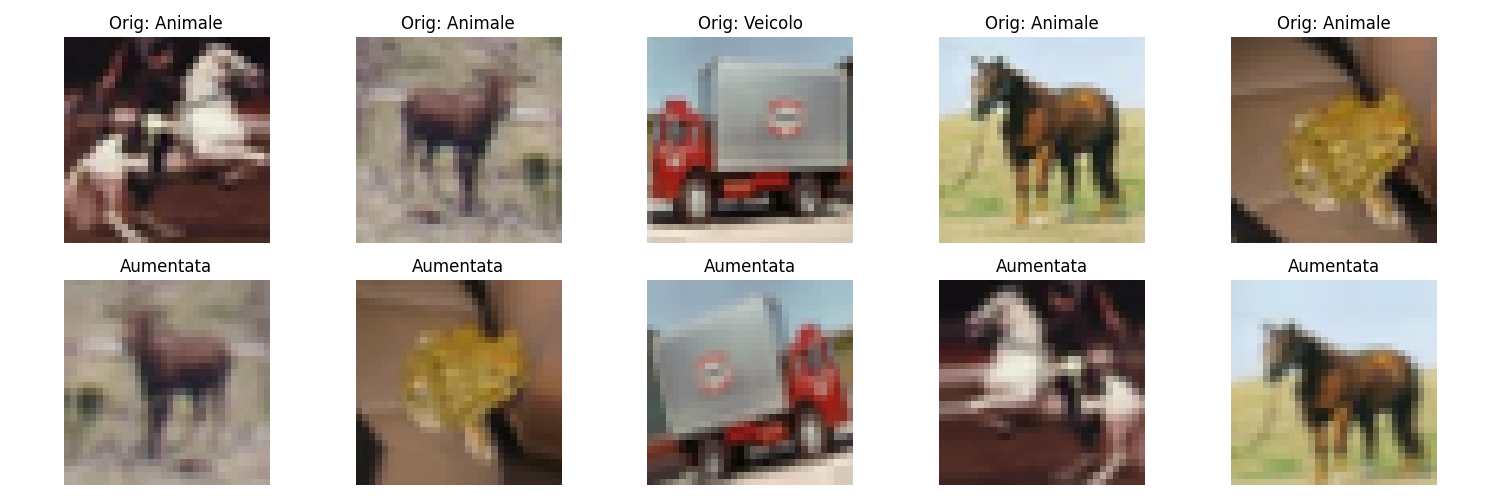

Re-usable create CNN function

In [17]:
def create_cnn_model(input_shape=(32, 32, 3)):
    """
    Crea un modello CNN per la classificazione binaria veicoli/animali
    """
    print("Creazione del modello CNN...")

    # Definiamo l'input layer esplicitamente
    inputs = keras.Input(shape=input_shape)

    # Primo blocco convoluzionale
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    # Secondo blocco convoluzionale
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Terzo blocco convoluzionale
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.4)(x)

    # Livelli completamente connessi
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(2, activation='softmax')(x)  # Output binario: veicolo o animale

    # Creazione del modello utilizzando il modello funzionale API
    model = keras.Model(inputs=inputs, outputs=outputs, name="vehicle_animal_classifier")

    # Compilazione del modello
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    return model

Train Model

In [ ]:
def train_model(model, train_generator, x_val, y_val, epochs=20):
    """
    Addestra il modello CNN con i dati preparati
    """
    print("Inizio addestramento del modello...")

    # Callback per salvare il miglior modello durante l'addestramento
    checkpoint_filepath = 'best_model_vehicle_animal.h5'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    # Callback per early stopping se non ci sono miglioramenti
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )

    # Callback per ridurre il learning rate se non ci sono miglioramenti
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=0.00001
    )

    # Addestramento del modello
    start_time = time.time()

    steps_per_epoch = len(train_generator)

    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=[model_checkpoint_callback, early_stopping, reduce_lr]
    )

    training_time = time.time() - start_time
    print(f"Addestramento completato in {training_time:.2f} secondi")

    # Carica il miglior modello (se è stato salvato)
    if os.path.exists(checkpoint_filepath):
        print(f"Caricamento del miglior modello da: {checkpoint_filepath}")
        model = keras.models.load_model(checkpoint_filepath)

    return model, history

In [ ]:
def visualize_training_history(history):
    """
    Visualizza i grafici dell'andamento dell'addestramento del modello
    """
    plt.figure(figsize=(12, 5))

    # Plot accuratezza
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuratezza del Modello')
    plt.ylabel('Accuratezza')
    plt.xlabel('Epoca')
    plt.legend(loc='lower right')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss del Modello')
    plt.ylabel('Loss')
    plt.xlabel('Epoca')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()
    print("Grafici di addestramento salvati in 'training_history.png'")


In [ ]:
def evaluate_model(model, x_test, y_test, class_names):
    """
    Valuta il modello addestrato sul set di test
    """
    print("\nValutazione del modello sul set di test...")
    test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")

    # Predizioni sul set di test
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Calcola e visualizza la matrice di confusione
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predizione')
    plt.ylabel('Valore Reale')
    plt.title('Matrice di Confusione')
    plt.savefig('confusion_matrix.png')
    plt.close()
    print("Matrice di confusione salvata in 'confusion_matrix.png'")

    # Report di classificazione
    print("\nReport di classificazione:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

    # Salvare il report di classificazione come CSV
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_report.to_csv('classification_report.csv')
    print("Report di classificazione salvato in 'classification_report.csv'")

    return y_pred, y_true_classes, y_pred_classes

In [ ]:
def visualize_incorrect_predictions(x_test, y_true_classes, y_pred_classes, class_names, n=20):
    """
    Visualizza esempi di predizioni errate per l'analisi dell'errore
    """
    incorrect_indices = np.where(y_true_classes != y_pred_classes)[0]

    if len(incorrect_indices) == 0:
        print("Nessuna predizione errata trovata!")
        return

    # Limita il numero di immagini da visualizzare
    n = min(n, len(incorrect_indices))

    plt.figure(figsize=(20, n))
    for i, idx in enumerate(incorrect_indices[:n]):
        plt.subplot(n // 4 + 1, 4, i + 1)
        plt.imshow(x_test[idx])
        plt.title(f"Vero: {class_names[y_true_classes[idx]]}\nPred: {class_names[y_pred_classes[idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('incorrect_predictions.png')
    plt.close()
    print(f"Esempi di {n} predizioni errate salvate in 'incorrect_predictions.png'")

In [23]:
def analyze_class_activation_maps(model, x_test, y_true_classes, class_names, n=5):
    """
    Analizza le mappe di attivazione della classe per capire su quali parti
    dell'immagine il modello si sta concentrando per fare la predizione.
    """
    try:
        # Crea un modello che restituisce sia la predizione che l'ultima mappa di attivazione convoluzionale
        last_conv_layer_name = None
        for layer in reversed(model.layers):
            if isinstance(layer, layers.Conv2D):
                last_conv_layer_name = layer.name
                break

        if last_conv_layer_name is None:
            print("Nessun layer convoluzionale trovato nel modello.")
            return

        # Modello per estrarre le mappe di attivazione
        grad_model = tf.keras.models.Model(
            inputs=[model.inputs],
            outputs=[
                model.get_layer(last_conv_layer_name).output,
                model.output
            ]
        )

        # Seleziona alcune immagini
        selected_indices = np.random.choice(len(x_test), n, replace=False)

        plt.figure(figsize=(15, n * 3))
        for i, idx in enumerate(selected_indices):
            img = x_test[idx]
            img_array = np.expand_dims(img, axis=0)

            # Calcola le mappe di attivazione
            with tf.GradientTape() as tape:
                conv_outputs, predictions = grad_model(img_array)
                class_idx = y_true_classes[idx]
                loss = predictions[:, class_idx]

            # Estrai gli output dell'ultimo layer convoluzionale
            output = conv_outputs[0]

            # Crea una mappa di calore ponderata
            weights = tape.gradient(loss, conv_outputs)[0]
            cam = np.mean(output * weights[..., np.newaxis], axis=(0, 1))

            cam = np.maximum(cam, 0)  # ReLU
            heatmap = cam / np.max(cam)

            # Ridimensiona la mappa di calore alle dimensioni dell'immagine originale
            import cv2
            heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

            # Converti la mappa di calore in RGB
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

            # Sovrapponi la mappa di calore all'immagine originale
            superimposed_img = heatmap * 0.4 + img * 255
            superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

            # Visualizza l'immagine originale e la mappa di calore
            plt.subplot(n, 2, i * 2 + 1)
            plt.imshow(img)
            plt.title(f"Originale: {class_names[class_idx]}")
            plt.axis('off')

            plt.subplot(n, 2, i * 2 + 2)
            plt.imshow(superimposed_img)
            plt.title("Mappa di Attivazione")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig('class_activation_maps.png')
        plt.close()
        print("Mappe di attivazione delle classi salvate in 'class_activation_maps.png'")
    except Exception as e:
        print(f"Errore durante la generazione delle mappe di attivazione: {e}")

In [ ]:
Image('class_activation_maps.png')
Image('incorrect_predictions.png')

In [18]:










def main():
    # Imposta la riproducibilità
    tf.random.set_seed(42)
    np.random.seed(42)

    print("Avvio del sistema di riconoscimento automatico veicoli-animali")
    print("=" * 70)

    # Parte 1: Preparazione dei dati
    print("\nPARTE 1: PREPARAZIONE DEI DATI")
    print("-" * 70)
    (x_train, y_train), (x_val, y_val), (x_test, y_test), class_names = load_and_prepare_cifar10()
    train_generator = create_data_generators(x_train, y_train)
    visualize_augmented_samples(x_train, y_train, class_names)

    # Parte 2: Addestramento del modello
    print("\nPARTE 2: ADDESTRAMENTO DEL MODELLO")
    print("-" * 70)
    model = create_cnn_model()
    trained_model, history = train_model(model, train_generator, x_val, y_val)
    visualize_training_history(history)

    # Parte 3: Valutazione e predizione
    print("\nPARTE 3: VALUTAZIONE E PREDIZIONE")
    print("-" * 70)
    y_pred, y_true_classes, y_pred_classes = evaluate_model(trained_model, x_test, y_test, class_names)
    visualize_incorrect_predictions(x_test, y_true_classes, y_pred_classes, class_names)
    analyze_class_activation_maps(trained_model, x_test, y_true_classes, class_names)

    # Salva il modello finale
    trained_model.save('vehicle_animal_classifier_final.h5')
    print("\nModello finale salvato come 'vehicle_animal_classifier_final.h5'")

    print("\nSistema di riconoscimento automatico completato con successo!")
    print("=" * 70)

if __name__ == "__main__":
    main()

Avvio del sistema di riconoscimento automatico veicoli-animali

PARTE 1: PREPARAZIONE DEI DATI
----------------------------------------------------------------------
Caricamento del dataset CIFAR-10...


KeyboardInterrupt: 